In [1]:
import pathlib
import warnings
from typing import List, Tuple

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
from sklearn.decomposition import PCA
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import (
    explained_variance_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.multioutput import MultiOutputRegressor

In [2]:
def shuffle_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Shuffle the data in the DataFrame.
    """
    df_shuffled = df.copy()
    for col in df_shuffled.columns:
        # permute the columns
        df_shuffled[col] = np.random.permutation(df_shuffled[col])
    return df_shuffled

In [3]:
# read in the data
sc_file_path = pathlib.Path("../results/cleaned_sc_profile.parquet").resolve(
    strict=True
)
sc_endpoint_file_path = pathlib.Path(
    "../results/cleaned_endpoint_sc_profile.parquet"
).resolve(strict=True)

train_test_wells_file_path = pathlib.Path(
    "../../5.bulk_timelapse_model/data_splits/train_test_wells.parquet"
).resolve(strict=True)
model_dir = pathlib.Path("../models").resolve()
model_dir.mkdir(parents=True, exist_ok=True)
results_dir = pathlib.Path("../results").resolve()
results_dir.mkdir(parents=True, exist_ok=True)
sc_profile = pd.read_parquet(sc_file_path)
sc_endpoint_profile = pd.read_parquet(sc_endpoint_file_path)
train_test_wells = pd.read_parquet(train_test_wells_file_path)
print(f"sc_profile shape: {sc_profile.shape}")
print(f"sc_endpoint_profile shape: {sc_endpoint_profile.shape}")
data_split_file_path = pathlib.Path("../results/data_splits.parquet").resolve()
data_splits = pd.read_parquet(data_split_file_path)
sc_profile["Metadata_Time"] = sc_profile["Metadata_Time"].astype(float).astype(int)

sc_profile shape: (185502, 2383)
sc_endpoint_profile shape: (4733, 545)


In [4]:
# load models
elastic_net_all_annexinv_features_model_path = pathlib.Path(
    "../models/train_elastic_net_all_annexinv_features_model.joblib"
).resolve(strict=True)
elastic_net_all_annexinv_features_model_shuffled_path = pathlib.Path(
    "../models/train_shuffled_elastic_net_all_annexinv_features_model_shuffled.joblib"
).resolve(strict=True)
elastic_net_single_terminal_features_model_path = pathlib.Path(
    "../models/train_elastic_net_single_terminal_features_model.joblib"
).resolve(strict=True)
elastic_net_single_terminal_features_model_shuffled_path = pathlib.Path(
    "../models/train_shuffled_elastic_net_single_terminal_features_model_shuffled.joblib"
).resolve(strict=True)

elastic_net_all_annexinv_features_model = joblib.load(
    elastic_net_all_annexinv_features_model_path
)
elastic_net_all_annexinv_features_model_shuffled = joblib.load(
    elastic_net_all_annexinv_features_model_shuffled_path
)
elastic_net_single_terminal_features_model = joblib.load(
    elastic_net_single_terminal_features_model_path
)
elastic_net_single_terminal_features_model_shuffled = joblib.load(
    elastic_net_single_terminal_features_model_shuffled_path
)

In [5]:
# remove any rows of index that are not in sc_profile
print(f"data_splits shape before filtering: {data_splits.shape}")
data_splits = data_splits[data_splits["index"].isin(sc_profile.index)]
print(f"data_splits shape after filtering: {data_splits.shape}")

data_splits shape before filtering: (185502, 3)
data_splits shape after filtering: (185502, 3)


In [6]:
data_splits.head()

,index,data_split,ground_truth
0,0,test,False
1,1,test,False
2,2,test,False
3,3,test,False
4,4,val,True


In [7]:
# get the testing data
testing_df_X = sc_profile.loc[data_splits["index"][data_splits["data_split"] == "test"]]

In [8]:
# testing_df_X =
testing_df_X = testing_df_X.loc[
    testing_df_X["Metadata_Time"] == testing_df_X["Metadata_Time"].max()
]

In [9]:
testing_df_y = sc_endpoint_profile.loc[
    sc_endpoint_profile["Metadata_sc_unique_track_id"].isin(
        testing_df_X["Metadata_sc_unique_track_id"]
    )
]
# if there is track ids in the X that are not in the y, remove them
testing_df_X = testing_df_X.loc[
    testing_df_X["Metadata_sc_unique_track_id"].isin(
        testing_df_y["Metadata_sc_unique_track_id"]
    )
]
print(
    f"testing_df_X shape: {testing_df_X.shape}",
    testing_df_X["Metadata_sc_unique_track_id"].nunique(),
)
print(
    f"testing_df_y shape: {testing_df_y.shape}",
    testing_df_y["Metadata_sc_unique_track_id"].nunique(),
)
assert (
    testing_df_X["Metadata_sc_unique_track_id"].nunique()
    == testing_df_y["Metadata_sc_unique_track_id"].nunique()
)
assert (
    testing_df_X["Metadata_sc_unique_track_id"].shape[0]
    == testing_df_y["Metadata_sc_unique_track_id"].shape[0]
)
testing_df_X_shuffled = testing_df_X.copy()
testing_df_X_shuffled = shuffle_data(testing_df_X_shuffled)

testing_df_X shape: (294, 2383) 294
testing_df_y shape: (294, 545) 294


In [10]:
test_x_metadata = [x for x in testing_df_X.columns if "Metadata" in x]
test_y_metadata = [y for y in testing_df_y.columns if "Metadata" in y]
testing_X_features = [x for x in testing_df_X.columns if x not in test_x_metadata]
testing_y_features = [y for y in testing_df_y.columns if y not in test_y_metadata]

test_x_shuffled_metadata = [x for x in testing_df_X_shuffled.columns if "Metadata" in x]
test_y_shuffled_metadata = [y for y in testing_df_y.columns if "Metadata" in y]
test_x_shuffled_features = [
    x for x in testing_df_X_shuffled.columns if x not in test_x_shuffled_metadata
]

test_df_x_metadata = testing_df_X[test_x_metadata]
test_df_y_metadata = testing_df_y[test_y_metadata]
test_df_x_features = testing_df_X[testing_X_features]
test_df_y_features = testing_df_y[testing_y_features]
test_df_x_shuffled_metadata = testing_df_X_shuffled[test_x_shuffled_metadata]
test_df_x_shuffled_features = testing_df_X_shuffled[test_x_shuffled_features]

In [11]:
annexin_feature = "Cytoplasm_Intensity_IntegratedIntensity_AnnexinV"

In [12]:
# elastic_net_all_annexinv_features_model
# elastic_net_all_annexinv_features_model_shuffled
# elastic_net_single_terminal_features_model
# elastic_net_single_terminal_features_model_shuffled

In [13]:
dict_of_train_tests = {
    "single_feature": {
        "test": {
            "X": test_df_x_features,
            "y": test_df_y_features[annexin_feature],
            "x_metadata": test_df_x_metadata,
            "y_metadata": test_df_y_metadata,
            "model": elastic_net_single_terminal_features_model,
            "model_name": "elastic_net_single_terminal_features_model",
        },
        "test_shuffled": {
            "X": test_df_x_shuffled_features,
            "y": test_df_y_features[annexin_feature],
            "x_metadata": test_df_x_shuffled_metadata,
            "y_metadata": test_df_y_metadata,
            "model": elastic_net_single_terminal_features_model_shuffled,
            "model_name": "elastic_net_single_terminal_features_model_shuffled",
        },
    },
    "annexinV_features": {
        "test": {
            "X": test_df_x_features,
            "y": test_df_y_features,
            "x_metadata": test_df_x_metadata,
            "y_metadata": test_df_y_metadata,
            "model": elastic_net_all_annexinv_features_model,
            "model_name": "elastic_net_all_annexinv_features_model",
        },
        "test_shuffled": {
            "X": test_df_x_shuffled_features,
            "y": test_df_y_features,
            "x_metadata": test_df_x_shuffled_metadata,
            "y_metadata": test_df_y_metadata,
            "model": elastic_net_all_annexinv_features_model_shuffled,
            "model_name": "elastic_net_all_annexinv_features_model_shuffled",
        },
    },
}

In [14]:
prediction_df_list = []
stats_df_list = []
# test the model
for model_type in dict_of_train_tests.keys():
    for train_test_key, train_test_data in tqdm.tqdm(
        dict_of_train_tests[model_type].items()
    ):
        print(f"Training model for {train_test_key}...{model_type}")
        X = train_test_data["X"]
        y = train_test_data["y"]
        x_metadata = dict_of_train_tests[model_type][train_test_key]["x_metadata"]
        y_metadata = dict_of_train_tests[model_type][train_test_key]["y_metadata"]
        # find the number of NaNs
        num_nans_X = X.isna().sum().sum()
        num_nans_y = y.isna().sum().sum()
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            y_pred = dict_of_train_tests[model_type][train_test_key]["model"].predict(X)
        print(f"y_pred shape: {y_pred.shape}")
        print(f"y shape: {y.shape}")
        r2 = r2_score(y, y_pred)
        evs = explained_variance_score(y, y_pred)
        mae = mean_absolute_error(y, y_pred)
        mse = mean_squared_error(y, y_pred)
        rmse = np.sqrt(mse)
        print(
            f"R2: {r2:.4f}, Explained Variance Score: {evs:.4f}, MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}"
        )
        predictions_df = pd.DataFrame(
            y_pred, columns=y.columns if len(y.shape) > 1 else [y.name]
        )
        predictions_df.insert(0, "Model_type", model_type)
        predictions_df.insert(1, "Train_test_key", train_test_key)
        predictions_df.insert(2, "Model_name", train_test_data["model_name"])
        predictions_df.insert(3, "dose", x_metadata["Metadata_dose"].values)
        predictions_df.insert(4, "time", x_metadata["Metadata_Time"].values)
        stats_df = pd.DataFrame(
            {
                "model_type": [model_type],
                "train_test_key": [train_test_key],
                "model_name": [train_test_data["model_name"]],
                "r2": [r2],
                "explained_variance_score": [evs],
                "mae": [mae],
                "mse": [mse],
                "rmse": [rmse],
            }
        )
        prediction_df_list.append(predictions_df)
        stats_df_list.append(stats_df)

100%|██████████| 2/2 [00:00<00:00, 16.93it/s]


Training model for test...single_feature
y_pred shape: (294,)
y shape: (294,)
R2: 0.0249, Explained Variance Score: 0.0305, MAE: 0.7155, MSE: 0.9941, RMSE: 0.9971
Training model for test_shuffled...single_feature
y_pred shape: (294,)
y shape: (294,)
R2: -0.0047, Explained Variance Score: 0.0000, MAE: 0.7227, MSE: 1.0244, RMSE: 1.0121


  0%|          | 0/2 [00:00<?, ?it/s]

Training model for test...annexinV_features


 50%|█████     | 1/2 [00:02<00:02,  2.55s/it]

y_pred shape: (294, 510)
y shape: (294, 510)
R2: 0.0525, Explained Variance Score: 0.0572, MAE: 0.7450, MSE: 1.1146, RMSE: 1.0557
Training model for test_shuffled...annexinV_features


100%|██████████| 2/2 [00:13<00:00,  6.98s/it]

y_pred shape: (294, 510)
y shape: (294, 510)
R2: -0.0048, Explained Variance Score: -0.0001, MAE: 0.7820, MSE: 1.2467, RMSE: 1.1166


In [15]:
predictions_df = pd.concat(prediction_df_list, axis=0).reset_index(drop=True)
stats_df = pd.concat(stats_df_list, axis=0).reset_index(drop=True)
predictions_df

,Model_type,Train_test_key,Model_name,dose,time,Cytoplasm_Intensity_IntegratedIntensity_AnnexinV,Cytoplasm_AreaShape_Area,Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_Eccentricity,Cytoplasm_AreaShape_Extent,...,Nuclei_Texture_Correlation_AnnexinV_3_00_256,Nuclei_Texture_Correlation_AnnexinV_3_01_256,Nuclei_Texture_Correlation_AnnexinV_3_02_256,Nuclei_Texture_Correlation_AnnexinV_3_03_256,Nuclei_Texture_Correlation_DNA_3_02_256,Nuclei_Texture_DifferenceVariance_AnnexinV_3_01_256,Nuclei_Texture_InverseDifferenceMoment_AnnexinV_3_03_256,Nuclei_Texture_InverseDifferenceMoment_DNA_3_03_256,Nuclei_Texture_SumAverage_AnnexinV_3_00_256,Nuclei_Texture_SumAverage_DNA_3_01_256
0,single_feature,test,elastic_net_single_terminal_features_model,39.06,12,-0.215907,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,single_feature,test,elastic_net_single_terminal_features_model,39.06,12,-0.299756,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,single_feature,test,elastic_net_single_terminal_features_model,0.61,12,0.123840,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,single_feature,test,elastic_net_single_terminal_features_model,0.61,12,0.252547,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,single_feature,test,elastic_net_single_terminal_features_model,0.61,12,0.198748,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,annexinV_features,test_shuffled,elastic_net_all_annexinv_features_model_shuffled,0.0,12,0.060717,-0.021635,0.267488,0.020166,-0.248661,...,-0.035653,-0.008628,-0.027241,-0.031192,-0.163532,-0.014838,0.028162,-0.051011,0.027316,0.469359
1172,annexinV_features,test_shuffled,elastic_net_all_annexinv_features_model_shuffled,9.77,12,0.060717,-0.036511,0.225928,0.020166,-0.248661,...,-0.035653,-0.008628,-0.027241,-0.031192,-0.163501,-0.014838,0.028162,-0.051011,0.027316,0.469359
1173,annexinV_features,test_shuffled,elastic_net_all_annexinv_features_model_shuffled,4.88,12,0.060717,-0.022090,0.156632,0.020166,-0.248661,...,-0.035653,-0.008628,-0.027241,-0.031192,-0.163138,-0.014838,0.028162,-0.051011,0.027316,0.469359
1174,annexinV_features,test_shuffled,elastic_net_all_annexinv_features_model_shuffled,0.0,12,0.060717,0.061548,0.260877,0.020166,-0.248661,...,-0.035653,-0.008628,-0.027241,-0.031192,-0.155268,-0.014838,0.028162,-0.051011,0.027316,0.469359


In [16]:
# save the predictions
predictions_file_path = results_dir / "model_test_predictions.parquet"
predictions_df.to_parquet(predictions_file_path, index=False)
stats_file_path = results_dir / "model_test_stats.parquet"
stats_df.to_parquet(stats_file_path, index=False)

In [17]:
predictions_df.head()

,Model_type,Train_test_key,Model_name,dose,time,Cytoplasm_Intensity_IntegratedIntensity_AnnexinV,Cytoplasm_AreaShape_Area,Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_Eccentricity,Cytoplasm_AreaShape_Extent,...,Nuclei_Texture_Correlation_AnnexinV_3_00_256,Nuclei_Texture_Correlation_AnnexinV_3_01_256,Nuclei_Texture_Correlation_AnnexinV_3_02_256,Nuclei_Texture_Correlation_AnnexinV_3_03_256,Nuclei_Texture_Correlation_DNA_3_02_256,Nuclei_Texture_DifferenceVariance_AnnexinV_3_01_256,Nuclei_Texture_InverseDifferenceMoment_AnnexinV_3_03_256,Nuclei_Texture_InverseDifferenceMoment_DNA_3_03_256,Nuclei_Texture_SumAverage_AnnexinV_3_00_256,Nuclei_Texture_SumAverage_DNA_3_01_256
0,single_feature,test,elastic_net_single_terminal_features_model,39.06,12,-0.215907,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,single_feature,test,elastic_net_single_terminal_features_model,39.06,12,-0.299756,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,single_feature,test,elastic_net_single_terminal_features_model,0.61,12,0.123840,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,single_feature,test,elastic_net_single_terminal_features_model,0.61,12,0.252547,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,single_feature,test,elastic_net_single_terminal_features_model,0.61,12,0.198748,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
predictions_df[
    (predictions_df["Train_test_key"] == "test")
    & (predictions_df["Model_type"] == "single_feature")
][annexin_feature].shape

(294,)

In [19]:
dict_of_train_tests["single_feature"]["test"]["y"].shape

(294,)

In [20]:
predictions_df["dose"] = predictions_df["dose"].astype(float)
predictions_df["dose"].dtype

dtype('float64')

In [21]:
np.unique(predictions_df["dose"]).tolist()

[0.0, 0.61, 1.22, 2.44, 4.88, 9.77, 19.53, 39.06, 78.13, 156.25]

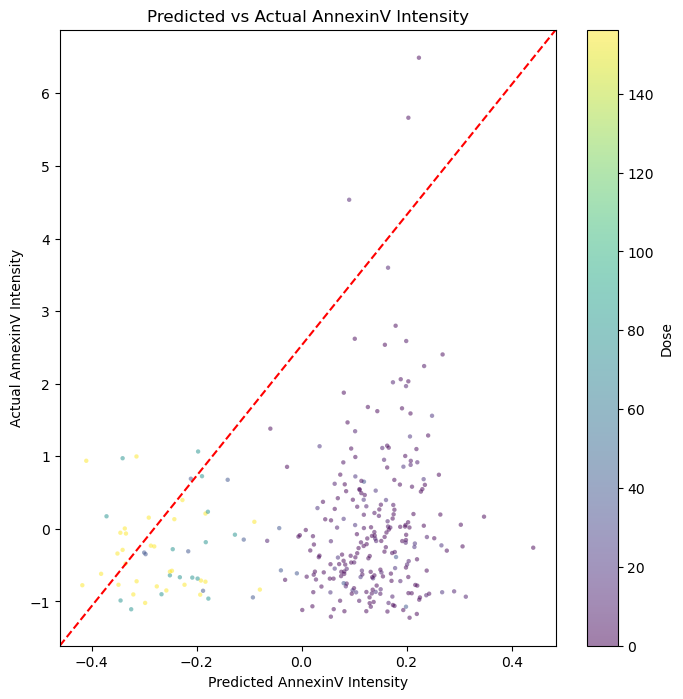

In [24]:
# plot the predictions vs actual for annexin_feature
plt.figure(figsize=(8, 8))

# Get the dose values for coloring
dose_values = dict_of_train_tests["single_feature"]["test"]["x_metadata"][
    "Metadata_dose"
].values
# Convert dose values to numeric to ensure proper colormap handling
dose_values = pd.to_numeric(dose_values, errors="coerce")

scatter = plt.scatter(
    predictions_df[
        (predictions_df["Train_test_key"] == "test")
        & (predictions_df["Model_type"] == "single_feature")
    ][annexin_feature],
    dict_of_train_tests["single_feature"]["test"]["y"],
    alpha=0.5,
    s=10,
    c=dose_values,
    cmap="viridis",
    edgecolors="none",
)

# Add colorbar to show dose mapping
plt.colorbar(scatter, label="Dose")

# plot a linear y=x line
plt.plot(
    [0, 1],
    [0, 1],
    transform=plt.gca().transAxes,
    color="red",
    linestyle="--",
)
plt.xlabel("Predicted AnnexinV Intensity")
plt.ylabel("Actual AnnexinV Intensity")
plt.title("Predicted vs Actual AnnexinV Intensity")
plt.show()